In [16]:
from taxii2client.v20 import Server, Collection
from pymongo import MongoClient
import datetime
from stix2 import parse
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.pyplot import figure
from pyvis.network import Network
import plotly.graph_objs as go
from plotly.offline import plot
import nbformat

In [17]:
mongo_client = MongoClient('localhost', 27017)
db = mongo_client.stix_database
collection = db.stix_data
G = nx.Graph()

In [18]:
server_url = 'https://cti-taxii.mitre.org/taxii/'

server = Server(server_url)

api_root = server.api_roots[0]

In [19]:
collection_id_enterprise = '95ecc380-afe9-11e4-9b6c-751b66dd541e'
taxii_collection1 = Collection(f"{api_root.url}collections/{collection_id_enterprise}/")

collection_id_pre = '062767bd-02d2-4b72-84ba-56caef0f8658'
taxii_collection2 = Collection(f"{api_root.url}collections/{collection_id_pre}/")

collection_id_mobile = '2f669986-b40b-4423-b720-4396ca6a462b'
taxii_collection3 = Collection(f"{api_root.url}collections/{collection_id_mobile}/")

collection_id_ics = '02c3ef24-9cd4-48f3-a99f-b74ce24f1d34'
taxii_collection4 = Collection(f"{api_root.url}collections/{collection_id_ics}/")

all_taxii_collections = [taxii_collection1, taxii_collection2, taxii_collection3, taxii_collection4]

In [20]:
for taxii_collection in all_taxii_collections:
    stix_objects = taxii_collection.get_objects()

    if stix_objects.get("objects"):
        for obj in stix_objects["objects"]:
            collection.update_one({"id": obj["id"]}, {"$set": obj}, upsert=True)


In [23]:
for taxii_collection in all_taxii_collections:    
    stix_objects = taxii_collection.get_objects().get('objects', [])

    for obj in stix_objects:
        if obj['type'] == 'relationship':
            G.add_edge(obj['source_ref'], obj['target_ref'], label=obj['relationship_type'])
        else:
            G.add_node(obj['id'], label=obj.get('name', obj.get('type')))


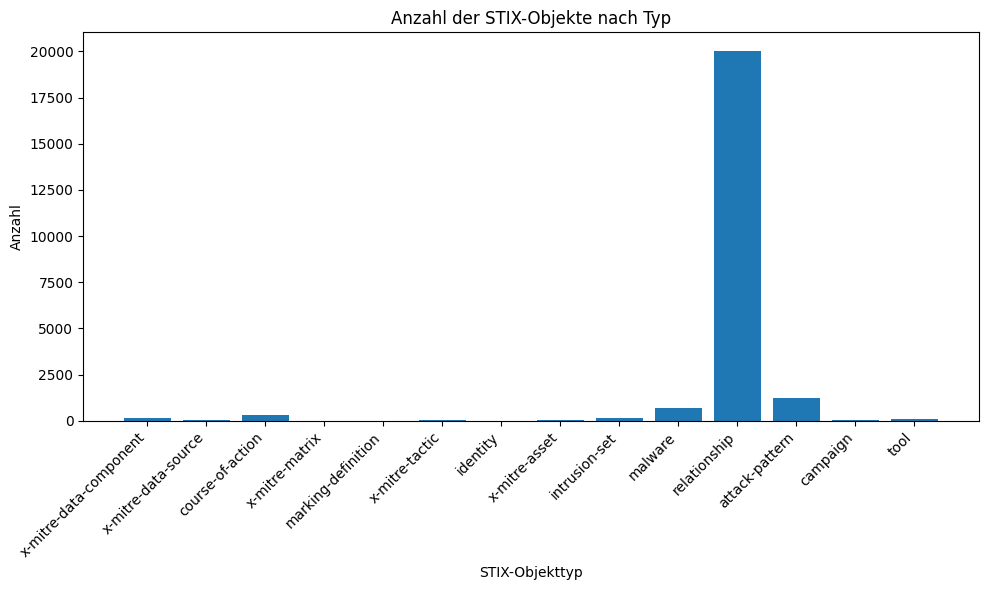

In [21]:
def analyze_types():
    pipeline = [
        {"$group": {"_id": "$type", "count": {"$sum": 1}}}
    ]
    return list(collection.aggregate(pipeline))
    
def visualize_data(data):
    labels = [elem['_id'] for elem in data]
    counts = [elem['count'] for elem in data]
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)
    plt.title('Anzahl der STIX-Objekte nach Typ')
    plt.xlabel('STIX-Objekttyp')
    plt.ylabel('Anzahl')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()  
    plt.show()
type_data = analyze_types()
visualize_data(type_data)

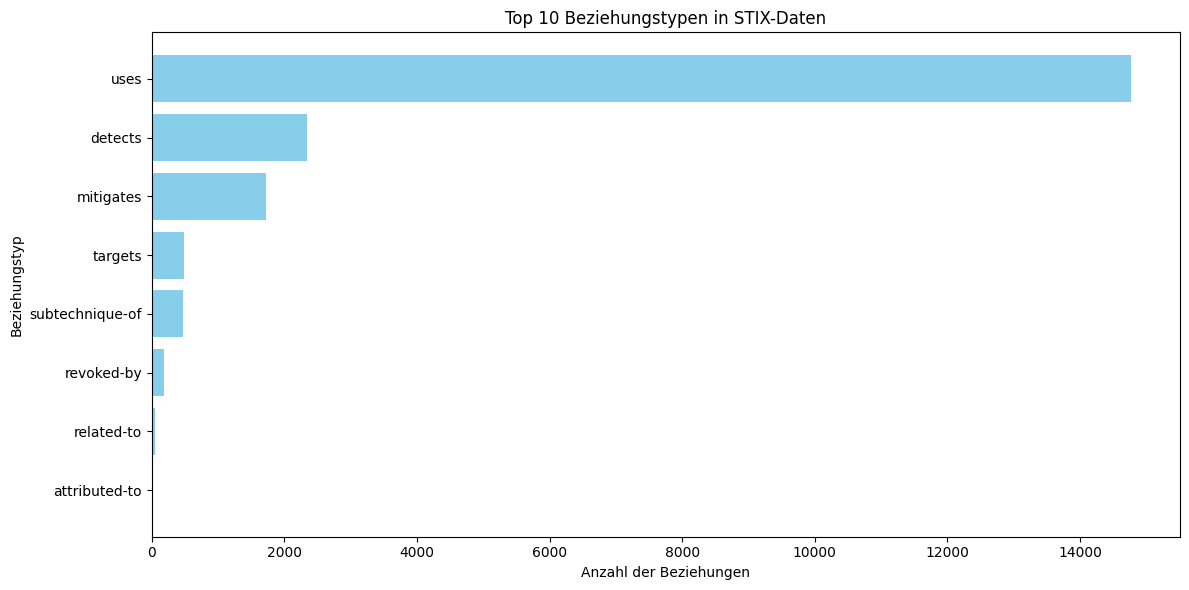

In [22]:
def analyze_relationships():
    pipeline = [
        {"$match": {"type": "relationship"}},
        {"$group": {"_id": "$relationship_type", "count": {"$sum": 1}}},
        {"$sort": {"count": -1}}  
    ]
    return list(collection.aggregate(pipeline))
def visualize_relationships(data):
    top_relationships = data[:10]  

    labels = [elem['_id'] for elem in top_relationships]
    counts = [elem['count'] for elem in top_relationships]
    
    plt.figure(figsize=(12, 6))
    plt.barh(labels, counts, color='skyblue')  
    plt.title('Top 10 Beziehungstypen in STIX-Daten')
    plt.xlabel('Anzahl der Beziehungen')
    plt.ylabel('Beziehungstyp')
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()
relationship_data = analyze_relationships()
visualize_relationships(relationship_data)

In [24]:

pos = nx.spring_layout(G)

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=text,
    textposition="bottom center",
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        line_width=2))

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Knowledge Graph mit Plotly',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python-Graphen-Visualisierung",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()